In [218]:
import os
import json
import numpy as np
import pandas as pd
from archetypal import settings
from pathlib import Path
from ladybug.epw import EPW
from uuid import uuid4
from shoeboxer.builder import ShoeboxConfiguration, ShoeBox
# from shoeboxer.schedules import default_schedules
from utils.constants import *
import torch
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract

# Check if we are running on Windows or Linux using os
if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

In [219]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, u

## Test version

In [220]:
# Get grasshopper json data for config
data_dir = "D:/DATA/SingleShoeboxTests"
# name = "Shoebox_split_parallel"
name = "Shoebox_split_horiz"
# name = "Shoebox_uniform"
# name = "Shoebox_uniform_adiabatic"
# name = "Shoebox_split_adiabatic"

gh_data_dir = Path(data_dir) / f"{name}.json"
gh_results_data_dir = Path(data_dir) / f"{name}_CSresults.json"
# gh_data_dir = "D:/DATA/SingleShoeboxTests/Shoebox_sched3.json"
with open(gh_data_dir, 'r') as f:
    gh_data = json.load(f)

In [221]:
def get_tmas_idx(val):
    if val >= ThermalMassCapacities.Concrete:
        hot_bin = ThermalMassConstructions.Concrete.value
    elif (
        val < ThermalMassCapacities.Concrete and val >= ThermalMassCapacities.Brick
    ):
        hot_bin = ThermalMassConstructions.Brick.value
    elif (
        val < ThermalMassCapacities.Brick and val >= ThermalMassCapacities.WoodFrame
    ):
        hot_bin = ThermalMassConstructions.WoodFrame.value
    elif val < ThermalMassCapacities.WoodFrame:
        hot_bin = ThermalMassConstructions.SteelFrame.value
    print(hot_bin)
    return hot_bin

In [222]:
float(gh_data["ShoeboxConfig"]["RoofMass"])*1000

483528.0

In [223]:
gh_data["Conditioning"]["MechVentSchedule"]

'Occupancy'

In [224]:
epw_path = "C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw"
epw_path = "data/epws/CAN_PQ_Montreal.Intl.AP.716270_CWEC.epw"
# epw_path ="C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw"
if gh_data["Conditioning"]["HeatRecoveryType"] == "None":
    hrv = 0
else:
    hrv = HRV[gh_data["Conditioning"]["HeatRecoveryType"]].value 
if "occ" in gh_data["Conditioning"]["MechVentSchedule"].lower():
    vent_mode = 2
else:
    vent_mode = 0 #TODO

config = {
    "FacadeMass": get_tmas_idx(float(gh_data["ShoeboxConfig"]["RoofMass"])*1000), 
    "RoofMass": get_tmas_idx(float(gh_data["ShoeboxConfig"]["FacadeMass"])*1000),
    "FacadeRValue": float(gh_data["ShoeboxConfig"]["FacadeRValue"]),
    "RoofRValue": float(gh_data["ShoeboxConfig"]["RoofRValue"]),
    "SlabRValue": float(gh_data["ShoeboxConfig"]["SlabRValue"]),
    "WindowUValue": float(gh_data["SimpleWindow"]["uval"]),
    "WindowShgc": float(gh_data["SimpleWindow"]["shgc"]),
    "PeopleDensity": float(gh_data["Loads"]["PeopleDensity"]),
    "EquipmentPowerDensity": float(gh_data["Loads"]["EquipmentPowerDensity"]),
    "LightingPowerDensity": float(gh_data["Loads"]["LightingPowerDensity"]),
    "HeatingSetpoint": float(gh_data["Conditioning"]["HeatingSetpoint"]),
    "CoolingSetpoint": float(gh_data["Conditioning"]["CoolingSetpoint"]),
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": vent_mode, #vent_mode, 2
    "VentilationPerArea": float(gh_data["Conditioning"]["MinFreshAirArea"]/1000),
    "VentilationPerPerson": float(gh_data["Conditioning"]["MinFreshAirPerson"]/1000),
    "EconomizerSettings": Econ[gh_data["Conditioning"]["EconomizerType"]].value,
    "RecoverySettings": hrv,
    "Infiltration": float(gh_data["Infiltration"]["InfiltrationFlowPerExteriorSurfaceArea"]), #/1000
    "wwr": float(gh_data["ShoeboxConfig"]["wwr"]),
    "roof_2_footprint": float(gh_data["ShoeboxConfig"]["roof_2_footprint"]),
    "ground_2_footprint": float(gh_data["ShoeboxConfig"]["ground_2_footprint"]),
    "orientation": float(gh_data["ShoeboxConfig"]["orientation"]),
    "width": float(gh_data["ShoeboxConfig"]["width"]),
    "height": float(gh_data["ShoeboxConfig"]["height"]),
    "perim_depth": float(gh_data["ShoeboxConfig"]["perim_depth"]),
    "core_depth": float(gh_data["ShoeboxConfig"]["core_depth"]),
    "building_idx": 0,
    "edge_length": 1,
    "edge_weight": 1,
    "weight": 1,
    "template_idx": 0.0,
    "floor_name": "none",
}
for i in range(12):
    config[f"shading_{i}"] = 0

0
0


In [225]:
"""
Make Schedules
"""
schedules = pd.read_hdf("data/schedules.h5")
idx = gh_data["ShoeboxConfig"]["schedule_index"]
print(idx)
scheds = schedules.loc[schedules.index[idx*3][0]].to_numpy()

5


In [226]:
"""
Make Shoebox
"""
sb_config = ShoeboxConfiguration()
sb_config.width = config["width"]
sb_config.height = config["height"]
sb_config.adiabatic_partition_flag = 0
sb_config.perim_depth = config["perim_depth"]
sb_config.core_depth = config["core_depth"]
sb_config.wwr = config["wwr"]
sb_config.roof_2_footprint = config["roof_2_footprint"]
sb_config.ground_2_footprint = config["ground_2_footprint"]
sb_config.shading_vect = np.zeros(12)
sb_config.orientation = config["orientation"]
template_dict = config.copy()
template_dict["schedules"] = scheds

sb = ShoeBox(
    name=str(uuid4()),
    epw=epw_path,
    shoebox_config=sb_config,
    template_dict=template_dict,
    output_directory="data/sim_results/"
)
idf = sb.idf(run_simulation=False)

"""
Simulate
"""

hourly_df, monthly_df = sb.simulate(idf=idf)
wb_shoebox_results = sb.postprocess(monthly_df)
annual = wb_shoebox_results.T.groupby(level=[0,1]).sum().T
annual

INFO:shoeboxer.geometry_utils:New perimeter depth: 3.0
INFO:shoeboxer.geometry_utils:New core depth: 9.0
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -2.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [2.5 0. ]


INFO:ShoeBox:Building idf for data\sim_results\d0b560ff-e773-487f-888b-294cbec72a1f.epjson
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.12.01 12:24
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.10sec
INFO:ShoeBox:Command executed successfully.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-d0b560ff-e773-487f-888b-294cbec72a1f.idf: 3.00it [00:00, 10.5it/s]
C:\EnergyPlusV22-2-0\energyplus.exe d0b560ff-e773-487f-888b-294cbec72a1f.idf: 63it [00:05, 11.84it/s]


KeyValue   Name   
Core       Cooling     0.677389
           Heating    27.498742
Perimeter  Cooling    19.370768
           Heating    80.545715
dtype: float64

In [227]:
# core, heating, cooling
out_file = str(gh_data_dir).split(".json")[0] + "_whitebox_out.csv"
print(out_file)
np.savetxt(out_file, np.resize(df.to_numpy(), (4,12)), delimiter=",")


D:\DATA\SingleShoeboxTests\Shoebox_split_horiz_whitebox_out.csv


In [228]:
climate = extract(EPW(epw_path))
features = pd.DataFrame(data=config, index=[0])

In [229]:
from ml.data import PredictBuildingDataset

dataset = PredictBuildingDataset(features, np.expand_dims(scheds, 0),climate, surrogate.space_config)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
shoebox_predictions = trainer.predict(surrogate, dataloader)
shoebox_predictions = torch.cat(shoebox_predictions)
try:
    shoebox_predictions = shoebox_predictions.cpu().numpy()
except:
    shoebox_predictions = shoebox_predictions.numpy()
shoebox_predictions[shoebox_predictions <= 0] = 0
shoebox_predictions = pd.DataFrame(
    shoebox_predictions,
    columns=surrogate.target_transform.columns,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]


In [230]:
import plotly.express as px
print(annual)
print(shoebox_predictions.T.groupby(level=[0,1]).sum().T)

KeyValue   Name   
Core       Cooling     0.677389
           Heating    27.498742
Perimeter  Cooling    19.370768
           Heating    80.545715
dtype: float64
KeyValue      Core           Perimeter           
Name       Cooling   Heating   Cooling    Heating
0         2.411144  27.13747  44.93383  71.584511


In [231]:
# core, heating, cooling
out_file = str(gh_data_dir).split(".json")[0] + "_surrogate_out.csv"
print(out_file)
np.savetxt(out_file, np.resize(shoebox_predictions.to_numpy(), (4,12)), delimiter=",")

D:\DATA\SingleShoeboxTests\Shoebox_split_horiz_surrogate_out.csv


In [232]:
with open(gh_results_data_dir, 'r') as f:
    gh_results_data = json.load(f)
gh_results = pd.DataFrame.from_dict(gh_results_data)

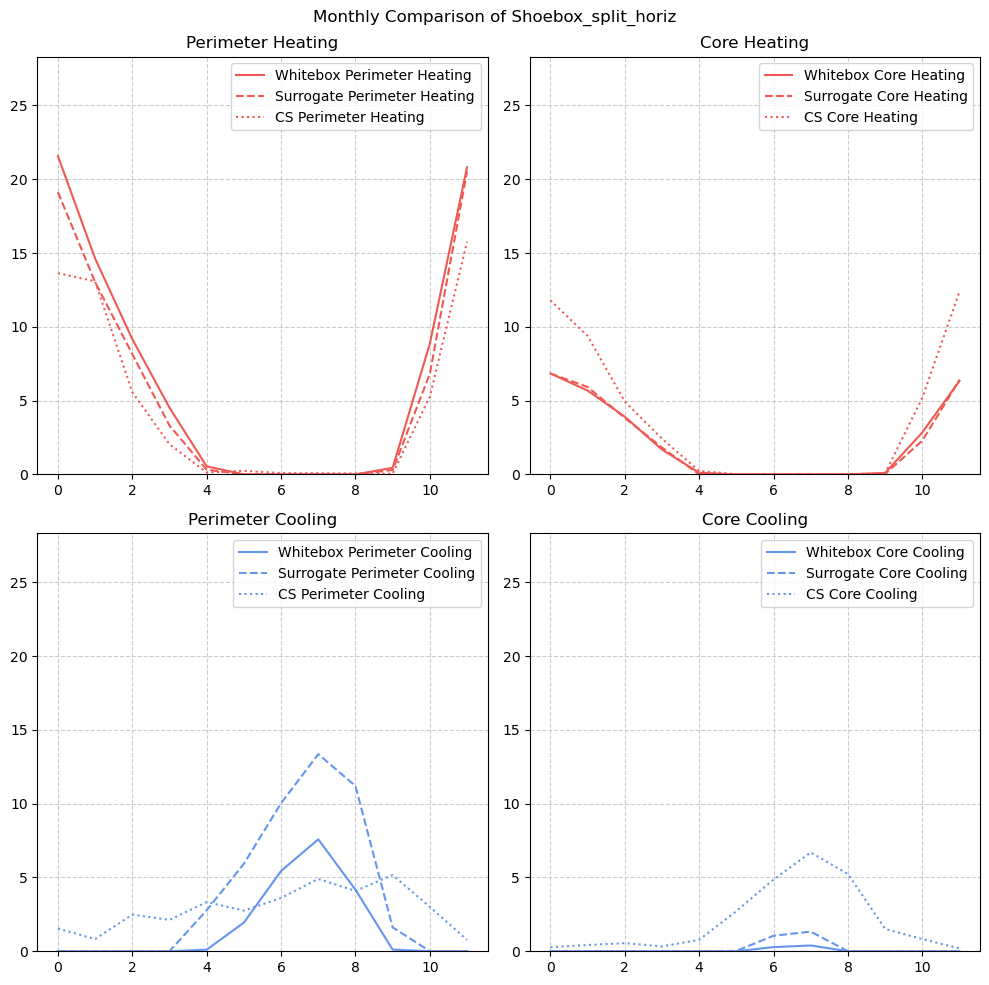

In [233]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


ix = -1
fig, axs = plt.subplots(2,2, figsize=(10,10))

for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        axs[row,col].set_title(f"{zone} {end_use}")
        axs[row,col].plot(wb_shoebox_results[zone][end_use].values, label=f"Whitebox {zone} {end_use}", color=color)
        axs[row,col].plot(shoebox_predictions[zone][end_use].values[ix], "--", label=f"Surrogate {zone} {end_use}", color=color)
        axs[row,col].plot(gh_results[f"{zone}_{end_use}"], ":", label=f"CS {zone} {end_use}", color=color)
        # legend
        axs[row,col].legend()
fig.tight_layout()
absolute_max = max(axs[0, 0].get_ylim()[1], axs[1, 0].get_ylim()[1])
grid_size = 5
while absolute_max / grid_size > 20:
    grid_size += 5 
for i in range(2):
    axs[0, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[0, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[1, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[1, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[0, i].set_ylim([0,1.25*absolute_max])
    axs[1, i].set_ylim([0,1.25*absolute_max])
plt.legend()
plt.suptitle(f"Monthly Comparison of {name}")
fig.tight_layout()

### Check geom

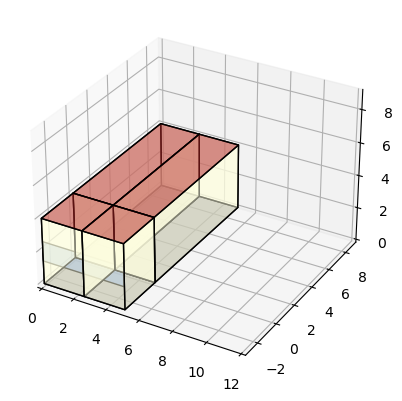

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [234]:
from archetypal import IDF
# Load idf from 
cs_idf = str(gh_data_dir).split(".json")[0] + ".idf"
cs_idf = IDF(cs_idf)
cs_idf.view_model()

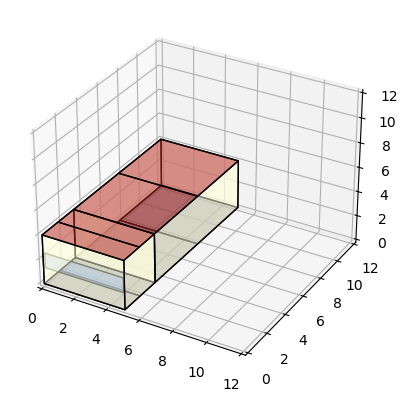

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [235]:
idf.view_model()

In [236]:
scheds.shape

(3, 8760)

### Check Scheds

In [237]:
from archetypal.schedule import Schedule
reference_schedules = np.load("./data/schedules.npy")

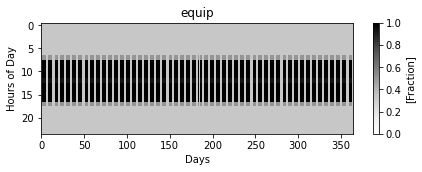

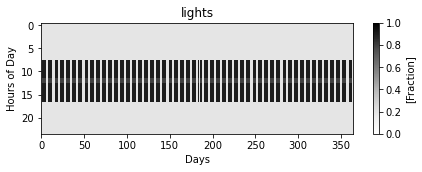

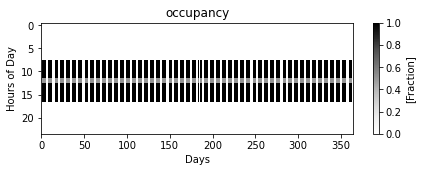

(<Figure size 504x144 with 2 Axes>,
 <Axes: title={'center': 'occupancy'}, xlabel='Days', ylabel='Hours of Day'>)

In [238]:
idx = 10
scheds = schedules.loc[schedules.index[idx*3][0]].to_numpy()
Schedule.from_values(Name="equip", Values=scheds[0]).plot2d()
Schedule.from_values(Name="lights", Values=scheds[1]).plot2d()
Schedule.from_values(Name="occupancy", Values=scheds[2]).plot2d()

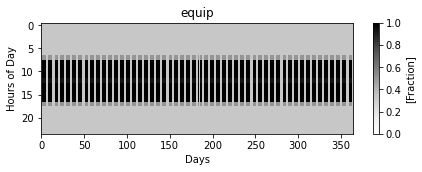

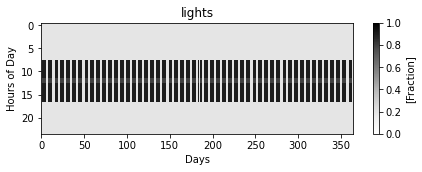

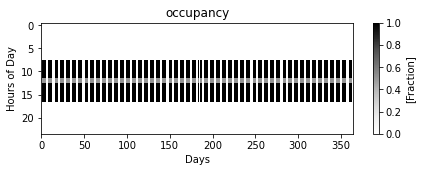

(<Figure size 504x144 with 2 Axes>,
 <Axes: title={'center': 'occupancy'}, xlabel='Days', ylabel='Hours of Day'>)

In [239]:
Schedule.from_values(Name="equip", Values=reference_schedules[idx][0]).plot2d()
Schedule.from_values(Name="lights", Values=reference_schedules[idx][1]).plot2d()
Schedule.from_values(Name="occupancy", Values=reference_schedules[idx][2]).plot2d()

## Compare epjsons

In [240]:
with open("D:/DATA/SingleShoeboxTests/Shoebox.epjson", "r") as f:
    cs_ep_json = json.load(f)

In [241]:
import jsondiff
diff_report = jsondiff.diff(
    sb.epjson, cs_ep_json, syntax="symmetric", dump=True
)
json.dump(json.loads(diff_report), open("D:/DATA/SingleShoeboxTests/json_compare.json", "w"), indent=4)